In [1]:
# Evaluation of reconstructed proteomic profiles by Spatial-DC on NSCLC data without Noise
# Yuan
# 20241120

In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import sys
from scipy import stats

import cell2location
import matplotlib.colors as mcolors

import warnings
from sklearn.preprocessing import MinMaxScaler,StandardScaler
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42



/data/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Global seed set to 0
2024-11-21 17:01:19.598087: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Visualization of reconstruction results without noise
- Fig. 2i - k

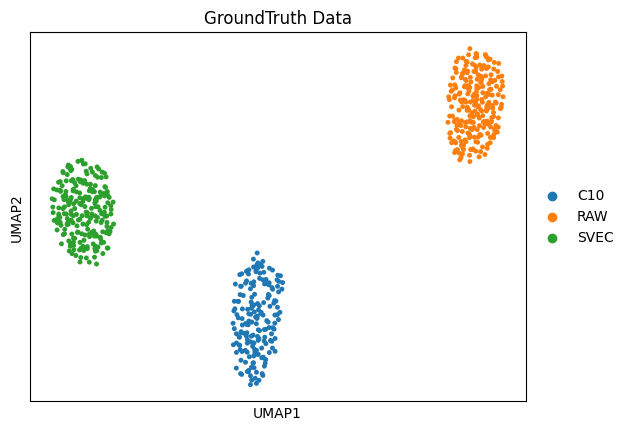

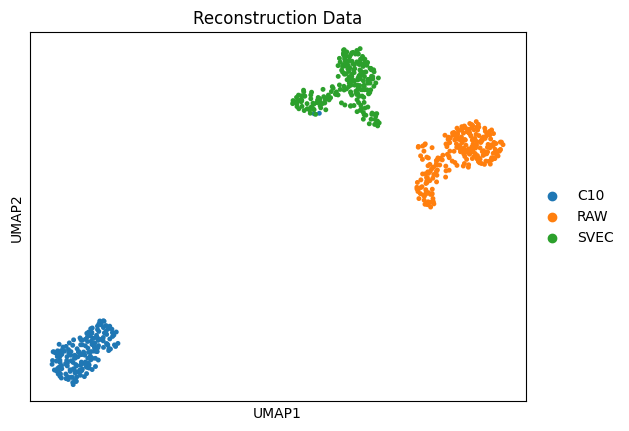

In [2]:
# visualization of cell-type and spatially reconstructed proteomics profiles from GroundTruth and SpatialDC
# Fig. 2i
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/Ablation_study/NSCLC_cond3")

# gd adata
projection_scp_adata = sc.read_h5ad("01_data/simulations/synthetic_cellnum_noise_v4/Simu_seed0_cells20_noise0_combined_celltype_exp.h5ad")
projection_scp_adata = projection_scp_adata[projection_scp_adata.obs["cellperc"] > 0,:]
sc.pp.filter_cells(projection_scp_adata, min_genes=10)
sc.pp.filter_genes(projection_scp_adata, min_cells=3)

# rec adata
rec_celltype_adata = sc.read_h5ad("03_output/exp_conditions_v4/SpatialDC/SpatialDC_reference_noise0_seed0_cells20_noise0_reconstruct_not_norm.h5ad")
rec_celltype_adata = rec_celltype_adata[rec_celltype_adata.obs["cellperc"] > 0,:]
sc.pp.filter_cells(rec_celltype_adata, min_genes=10)
sc.pp.filter_genes(rec_celltype_adata, min_cells=3)

# intersected
intersected_ct = np.intersect1d(projection_scp_adata.obs.index, rec_celltype_adata.obs.index)
intersected_pid = np.intersect1d(projection_scp_adata.var_names, rec_celltype_adata.var_names)

projection_scp_adata = projection_scp_adata[intersected_ct,intersected_pid].copy()
rec_celltype_adata = rec_celltype_adata[intersected_ct,intersected_pid].copy()

# celltype
# RAW     241
# SVEC    223
# C10     183
# Total 647
# Proteins
# 1003


sc.pp.normalize_total(projection_scp_adata)
sc.pp.log1p(projection_scp_adata)
sc.pp.scale(projection_scp_adata)
sc.pp.pca(projection_scp_adata)
sc.pp.neighbors(projection_scp_adata, n_neighbors=40, n_pcs=40)
# sc.pp.neighbors(projection_scp_adata)
sc.tl.umap(projection_scp_adata)
sc.pl.umap(projection_scp_adata, color=['celltype'],size=50,title="GroundTruth Data", save=" GroundTruth.pdf") # 1437 proteins and 12 celltypes

sc.pp.normalize_total(rec_celltype_adata)
sc.pp.log1p(rec_celltype_adata)
sc.pp.scale(rec_celltype_adata)
sc.pp.pca(rec_celltype_adata)
sc.pp.neighbors(rec_celltype_adata, n_neighbors=40, n_pcs=40)
# sc.pp.neighbors(rec_celltype_adata)
sc.tl.umap(rec_celltype_adata)
sc.pl.umap(rec_celltype_adata, color=["celltype"], size=50, title="Reconstruction Data", save=" Reconstruction.pdf")

In [ ]:
# Eva CCC, RMSE, PCC and SPCC
# run with R scripts
# Fig. 2j

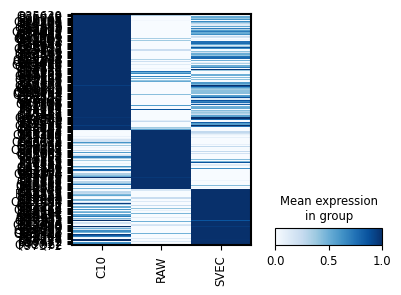

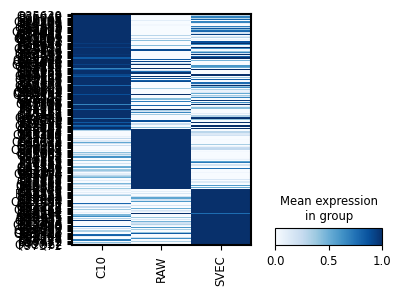

In [10]:
# Eva DEP from GroundTruth and Reconstructions
# Fig. 2k

os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/Ablation_study/NSCLC_cond3")
def get_dep(adata):
    sc.tl.rank_genes_groups(adata, 'celltype', method='t-test')
    result_dict = adata.uns['rank_genes_groups']
    df_list = []
    for celltype in result_dict["names"].dtype.names:
        df = pd.DataFrame(result_dict["scores"][celltype], columns=["score"])
        df["pvals_adj"] = result_dict["pvals_adj"][celltype]
        df["logfoldchanges"] = result_dict["logfoldchanges"][celltype]
        df["celltype"] = celltype
        df["feature"] = result_dict["names"][celltype]
        df_list.append(df)
    merged_df = pd.concat(df_list)
    merged_df = merged_df[merged_df["pvals_adj"] < 0.05] 
    merged_df = merged_df[merged_df["logfoldchanges"] > 0] 
    return(merged_df)

projection_scp_adata = sc.read_h5ad("01_data/reference/scp2019_1003_Reference.h5ad") # for synthetic spatial data
ref_scp_adata = sc.read_h5ad("01_data/reference/scp2021_1003_Reference.h5ad") # for reference of deconvoliution

# rec adata by Spatial-DC
rec_celltype_adata = sc.read_h5ad("03_output/exp_conditions_v4/SpatialDC/SpatialDC_reference_noise0_seed0_cells20_noise0_reconstruct_norm.h5ad")
rec_celltype_adata = rec_celltype_adata[rec_celltype_adata.obs["cellperc"] > 0,:]
sc.pp.filter_cells(rec_celltype_adata, min_genes=10)
sc.pp.filter_genes(rec_celltype_adata, min_cells=3)
# sc.pp.filter_genes(rec_celltype_adata, min_counts=1)

# intersected
intersected_pid = np.intersect1d(projection_scp_adata.var_names, rec_celltype_adata.var_names)

projection_scp_adata = projection_scp_adata[:,intersected_pid].copy()
rec_celltype_adata = rec_celltype_adata[:,intersected_pid].copy()
ref_scp_adata = ref_scp_adata[:,intersected_pid].copy()


sc.pp.log1p(rec_celltype_adata)
sc.pp.log1p(projection_scp_adata)
sc.pp.log1p(ref_scp_adata)

merged_df_1 = get_dep(projection_scp_adata)
merged_df_2 = get_dep(ref_scp_adata)

merged_df_1.index = merged_df_1["celltype"] +"_"+ merged_df_1["feature"]
merged_df_2.index = merged_df_2["celltype"] +"_"+ merged_df_2["feature"]

merged_df_1 = merged_df_1[merged_df_1.index.isin(np.intersect1d(merged_df_1.index, merged_df_2.index))]

# proteins
# C10     103
# RAW      52
# SVEC     48
# Total:203

# ax=sc.pl.matrixplot(ref_scp_adata, merged_df_1["feature"],'celltype',return_fig=True,dendrogram=False,swap_axes="False",figsize=[4,3],cmap="Blues",standard_scale="var")
# ax.edge_color="none"
# # ax.show()
# ax.savefig("04_analysis/eva_reconstruction/DEP_pheatmap_reference.pdf")

# reverse color map
ax=sc.pl.matrixplot(projection_scp_adata, merged_df_1["feature"],'celltype',return_fig=True,dendrogram=False,swap_axes="False",figsize=[4,3],cmap="Blues",standard_scale="var")#coolwarm
ax.edge_color="none"
# ax.show()
ax.savefig("04_analysis/eva_reconstruction/DEP_pheatmap_projection.pdf")

ax=sc.pl.matrixplot(rec_celltype_adata, merged_df_1["feature"],'celltype',return_fig=True,dendrogram=False,swap_axes="False",figsize=[4,3],cmap="Blues",standard_scale="var")
ax.edge_color="none"
# ax.show()
ax.savefig("04_analysis/eva_reconstruction/DEP_pheatmap_reconstruction.pdf")

# reverse color map
# ax=sc.pl.matrixplot(projection_scp_adata, merged_df_1["feature"],'celltype',return_fig=True,dendrogram=False,swap_axes="False",figsize=[4,3],cmap="Blues_r",standard_scale="var")#coolwarm
# ax.edge_color="none"
# # ax.show()
# ax.savefig("04_analysis/eva_reconstruction/DEP_pheatmap_projection_reverse.pdf")

# ax=sc.pl.matrixplot(rec_celltype_adata, merged_df_1["feature"],'celltype',return_fig=True,dendrogram=False,swap_axes="False",figsize=[4,3],cmap="Blues_r",standard_scale="var")
# ax.edge_color="none"
# # ax.show()
# ax.savefig("04_analysis/eva_reconstruction/DEP_pheatmap_reconstruction_reverse.pdf")